In [ ]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')
nb_path = '/content/notebooks'
os.symlink('/content/drive/My Drive/Colab Notebooks', nb_path)
sys.path.insert(0,nb_path)

Mounted at /content/drive


In [ ]:
# #!pip3 install virtualenv
# #!virtualenv /content/drive/MyDrive/colab_env

import sys
sys.path.append("/content/drive/MyDrive/colab_env/lib/python3.10/site-packages")

In [ ]:
#!source /content/drive/MyDrive/colab_env/bin/activate; pip install fastapi

In [ ]:
# !pip install -U mne
# !pip install ijson
# !pip install python-picard
# !pip install https://api.github.com/repos/autoreject/autoreject/zipball/master
# !pip install --upgrade mne
# !pip install PyQt5
# !pip install PyQt6
# !pip install headless
# !pip install autoreject

# Importing Necessary Libraries

In [ ]:
import mne
import mne.viz
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os
from mne.io import concatenate_raws, read_raw_edf
# from mne.preprocessing import ICA

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly import tools
from autoreject import AutoReject as ar

# from mne import utils
from warnings import simplefilter
simplefilter(action='ignore', category=UserWarning)

ModuleNotFoundError: ignored

# Importing Raw Data

In [ ]:
# fname = 'sub-umf001_ses-presurgery_task-ictal_acq-ecog_run-01_ieeg.eeg'
data_path = '/content/drive/MyDrive/Project files/dsp/'
# vhdr_file = os.path.join(data_path, 'sub-jh101_ses-presurgery_task-ictal_acq-ecog_run-01_ieeg.vhdr')
eeg_file = os.path.join(data_path, 'trial2.set')
fdt_file = os.path.join(data_path, 'trial2.fdt')

### Try / Except Loop
This loop is used to overcome the probabilistic error, where there was problem related to sampling

In [ ]:
while True:
    try:
        # Import the BrainVision data into an MNE Raw object
        #raw2 = mne.io.read_raw_brainvision(vhdr_file, preload=True)
        raw1 = mne.io.read_raw_eeglab(eeg_file, preload = True)
        #raw1.save('trial1.fif')
    except:
         continue
    else:
         #the rest of the code
         break


Reading /content/drive/MyDrive/Project files/dsp/trial2.fdt
Reading 0 ... 161269  =      0.000 ...   322.538 secs...


# Getting Info on the RAW EEG File

In [ ]:
info = raw1.info
info_df = pd.DataFrame.from_dict(info, orient='index')

In [ ]:
info_df

0
acq_pars                                                         None
acq_stim                                                         None
ctf_head_t                                                       None
description                                                      None
dev_ctf_t                                                        None
dig                 [{'kind': 3 (FIFFV_POINT_EEG), 'r': [nan, nan,...
experimenter                                                     None
utc_offset                                                       None
device_info                                                      None
file_id                                                          None
highpass                                                          0.0
hpi_subsystem                                                    None
kit_system_id                                                    None
helium_info                                                      None
line_freq                                                        None
lowpass                                                         250.0
meas_date                                                        None
meas_id                                                          None
proj_id                                                          None
proj_name                                                        None
subject_info                                                     None
xplotter_layout                                                  None
gantry_angle                                                     None
bads                                                               []
chs                 [{'loc': [nan, nan, nan, nan, nan, nan, nan, n...
comps                                                              []
events                                                             []
hpi_meas                                                           []
hpi_results                                                        []
projs                                                              []
proc_history                                                       []
custom_ref_applied                       0 (FIFFV_MNE_CUSTOM_REF_OFF)
sfreq                                                           500.0
dev_head_t          {'from': 1, 'to': 4, 'trans': [[1.0, 0.0, 0.0,...
ch_names            [FP1, FP2, F7, F3, FZ, F4, F8, FC5, FC1, FC2, ...
nchan                                                              67

# **Extracting** Raw Channel Names
Getting the channel names from the eeg file to know which international system it aligns with

In [ ]:
info_ch_df = pd.DataFrame.from_dict(info['chs'])
cn = info_ch_df['ch_name'].to_numpy()
#channel_names
cn

array(['FP1', 'FP2', 'F7', 'F3', 'FZ', 'F4', 'F8', 'FC5', 'FC1', 'FC2',
       'FC6', 'T7', 'C3', 'CZ', 'C4', 'T8', 'TP9', 'CP5', 'CP1', 'CP2',
       'CP6', 'TP10', 'P7', 'P3', 'PZ', 'P4', 'P8', 'PO9', 'O1', 'OZ',
       'O2', 'PO10', 'AF7', 'AF3', 'AF4', 'AF8', 'F5', 'F1', 'F2', 'F6',
       'FT9', 'FT7', 'FC3', 'FC4', 'FT8', 'FT10', 'C5', 'C1', 'C2', 'C6',
       'TP7', 'CP3', 'CPZ', 'CP4', 'TP8', 'P5', 'P1', 'P2', 'P6', 'PO7',
       'PO3', 'POZ', 'PO4', 'PO8'], dtype=object)


These channel names represent the placement of electrodes on the scalp for electroencephalography (EEG) recording. The letters correspond to specific brain regions:

F: Frontal lobe

T: Temporal lobe

C: Central region

P: Parietal lobe

O: Occipital lobe

AF: Anterofrontal region

FP: Frontal pole

FC: Frontocentral region

CP: Centroparietal region

TP: Temporoparietal region

PO: Parietooccipital region

OZ: Occipital midline

### Extracting the coordinates of sensors

In [ ]:
channels_of_interest = ['x_dir', 'y_dir', 'z_dir']
missing_channels = [ch for ch in channels_of_interest if ch not in raw1.ch_names]

if missing_channels:
    print(f"Channels {missing_channels} not found in the raw data.")
else:
    # Extract data from specified channels
    data, times = raw1[channels_of_interest, :]

    # Do something with the extracted data, e.g., print the first few samples


# Number of time points
num_time_points = data.shape[1]

# Number of channels
num_channels = data.shape[0]

# Assuming the order is 'x_dir', 'y_dir', 'z_dir'
x_pos = data[0, :]
y_pos = data[1, :]
z_pos = data[2, :]

### Coordinates of the channels

In [ ]:
num_time_points

161270

In [ ]:
num_channels

3

In [ ]:
x_pos,y_pos,z_pos

(array([-0.000872, -0.000872, -0.000873, ..., -0.000909, -0.000912,
        -0.000912]),
 array([ 1.77e-04,  1.77e-04,  1.77e-04, ..., -6.10e-05, -6.10e-05,
        -6.10e-05]),
 array([-0.000272, -0.000272, -0.000276, ...,  0.000395,  0.000396,
         0.000396]))

In [ ]:
raw1.drop_channels(ch_names = channels_of_interest)

<RawEEGLAB | trial2.fdt, 64 x 161270 (322.5 s), ~78.8 MB, data loaded>

# Creating Montage
A montage in EEG signal analysis is a specific arrangement of electrodes on the scalp used to record and analyze brain activity.

In [ ]:
raw1.set_montage('standard_1020', match_case = False)

<RawEEGLAB | trial2.fdt, 64 x 161270 (322.5 s), ~78.8 MB, data loaded>

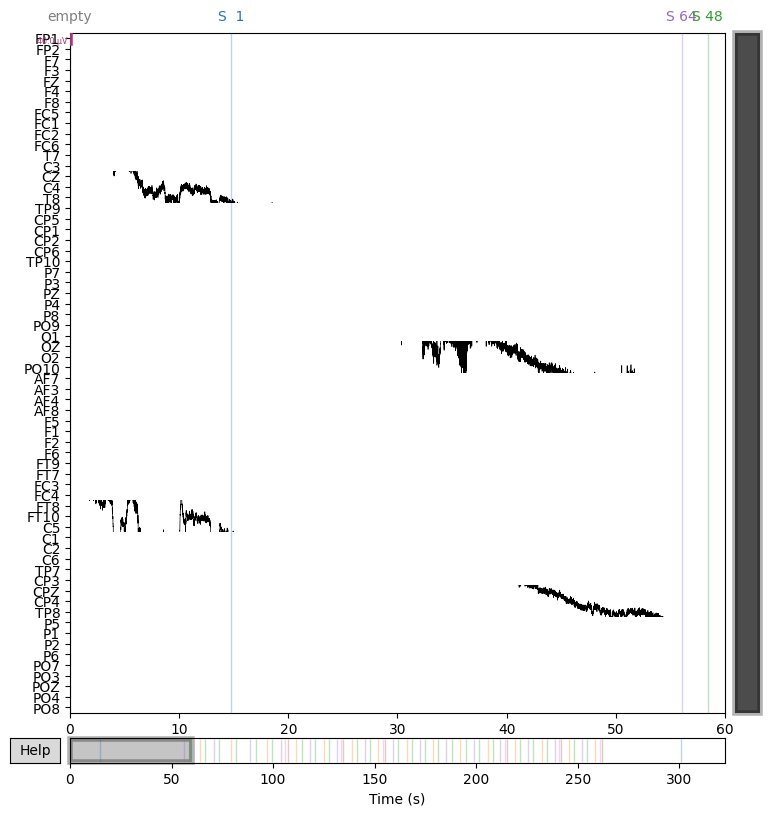

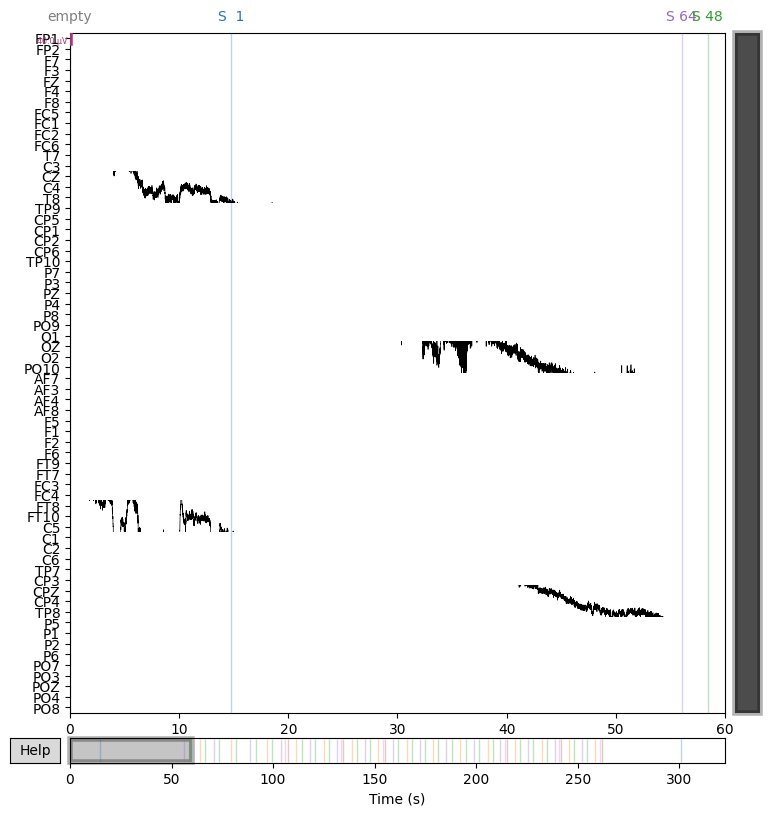

In [ ]:
raw1.plot(duration=60, order=eeg_channels, n_channels=len(eeg_channels), remove_dc=False)

Effective window size : 4.096 (s)


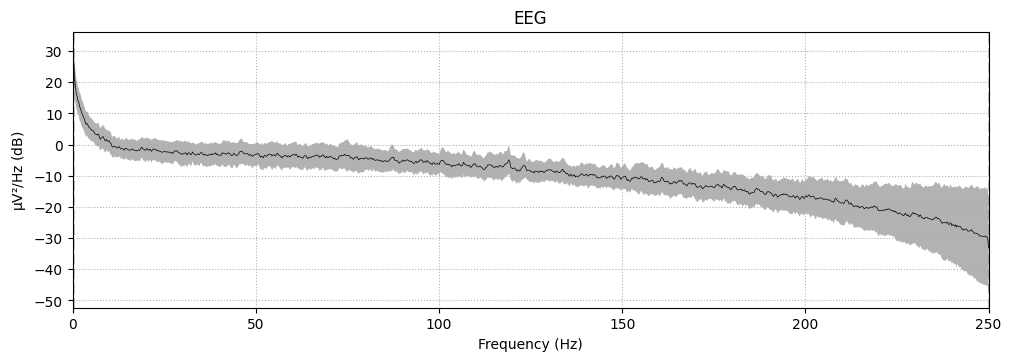

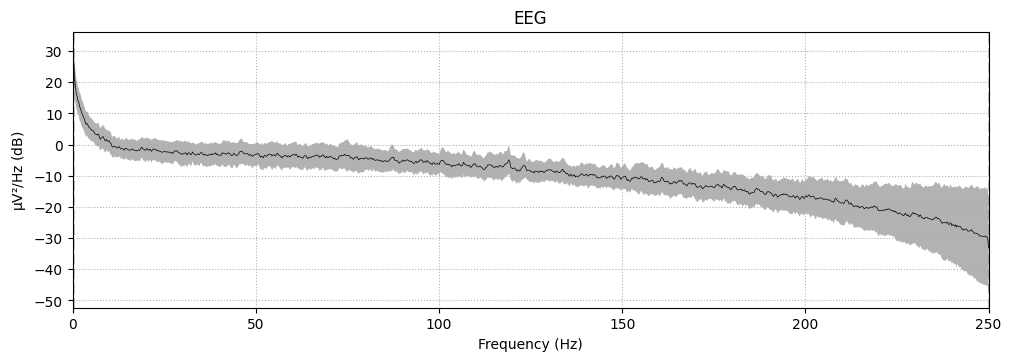

In [ ]:
raw1.compute_psd(fmax = 250).plot(average=True, picks="data", exclude="bads")

# Extracting Events From Annotation

In [ ]:
events, event_id = mne.events_from_annotations(raw1, event_id='auto')
event_id

Used Annotations descriptions: ['S  1', 'S 32', 'S 48', 'S 64', 'S 80', 'S 96', 'empty']


{'S  1': 1, 'S 32': 2, 'S 48': 3, 'S 64': 4, 'S 80': 5, 'S 96': 6, 'empty': 7}

These event markers were annotated by those who collected the data
- Numbers/Events in EEG marker file -
Sync:
EMG start/stop (trigger): S1


Movements:

Start of flexion: S 64

Start of extension: S 32

Standards event (mid of movement, no error introduced): S 48

Error introduction: S 96

Button press (response): S 80


In [ ]:
event_dict = {
        "Start of flexion": 4,
    "Start of extension": 2,
    "Standards event": 3,
    "Error introduction": 6,
    "buttonpress": 5
}

In [ ]:
raw1_eeg = raw1.copy().pick_types(meg=False, eeg=True, eog=False, exclude=[])

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


# Filtering

The notch filter aims to eliminate electrical noise from the power line interference, which is typically around 60 Hz in most regions

In [ ]:
raw1_eeg_filtered = raw1_eeg.copy().notch_filter(60);

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


the filter allows signals between 1.0 Hz and 50.0 Hz to pass through, while attenuating signals outside this range

In [ ]:
raw1_eeg_filtered = raw1_eeg_filtered.filter(l_freq=1.0, h_freq=90.0);

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 90 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 90.00 Hz
- Upper transition bandwidth: 22.50 Hz (-6 dB cutoff frequency: 101.25 Hz)
- Filter length: 1651 samples (3.302 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


# Plotting Power Spectral Density

Effective window size : 4.096 (s)


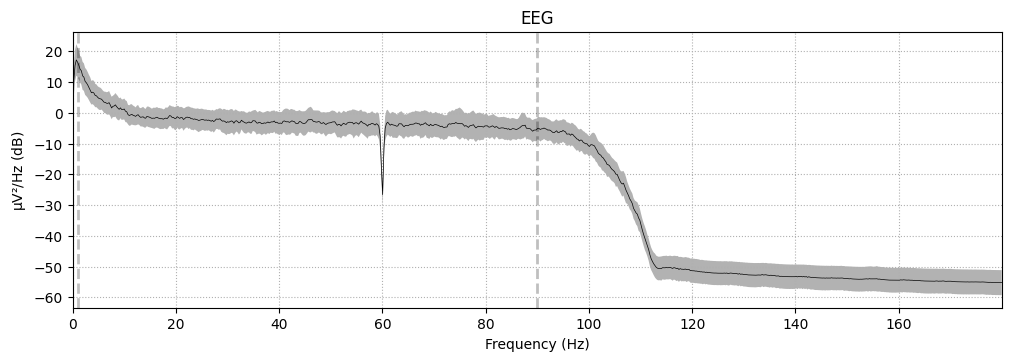

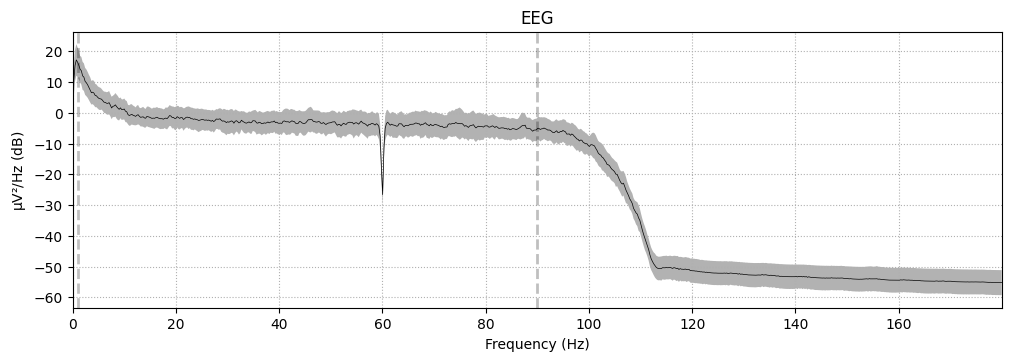

In [ ]:
raw1_eeg_filtered.compute_psd(fmax = 180).plot(average=True, picks="data", exclude="bads")
#plt.title('PSD before filtering')

# PSD Comparison Before and After filtering

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.096 (s)
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.096 (s)


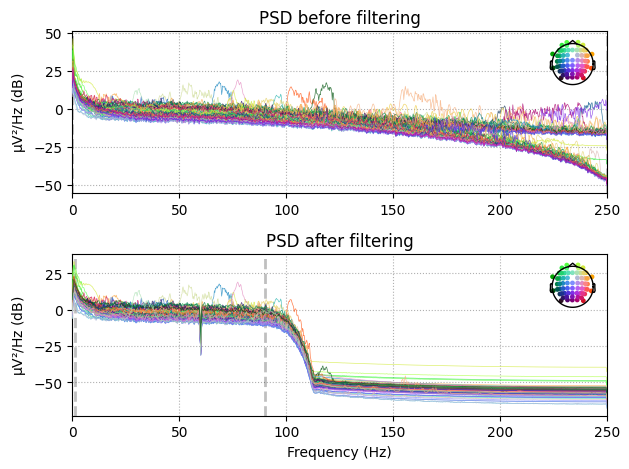

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2)

raw1.plot_psd(ax=ax[0], show=False)
raw1_eeg_filtered.plot_psd(ax=ax[1], show=False)

ax[0].set_title('PSD before filtering')
ax[1].set_title('PSD after filtering')
ax[1].set_xlabel('Frequency (Hz)')
fig.set_tight_layout(True)
plt.show()

# Resampling
Resampling to a common sampling rate, such as 180 Hz, allows for easier comparison and analysis of EEG data from different sources.

Cut off freq 90Hz
So Fs is 200 Hz

In [ ]:
raw1_eeg_filtered_resampled = raw1_eeg_filtered.copy().resample(200, npad='auto')

Effective window size : 10.240 (s)


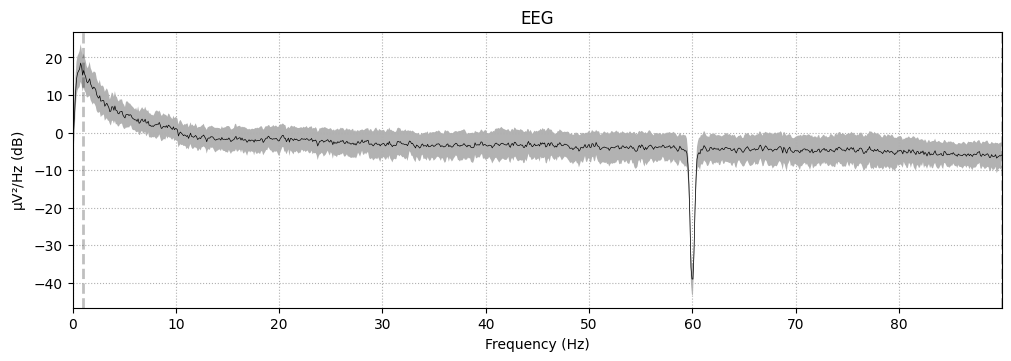

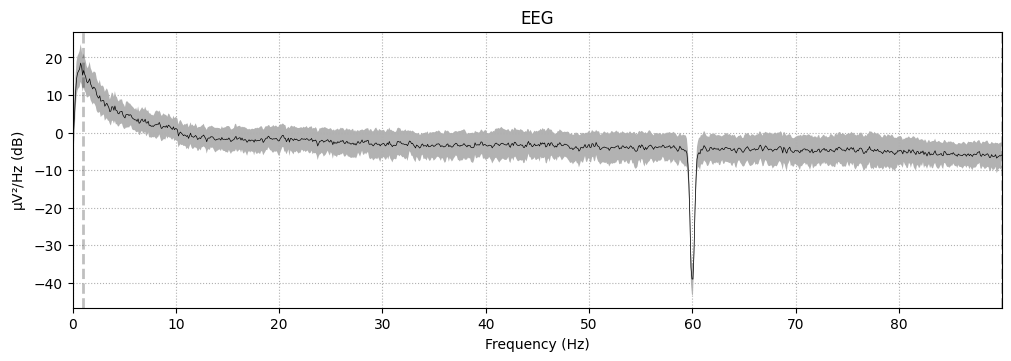

In [ ]:
raw1_eeg_filtered_resampled.compute_psd(fmax = 90).plot(average=True, picks="data", exclude="bads")

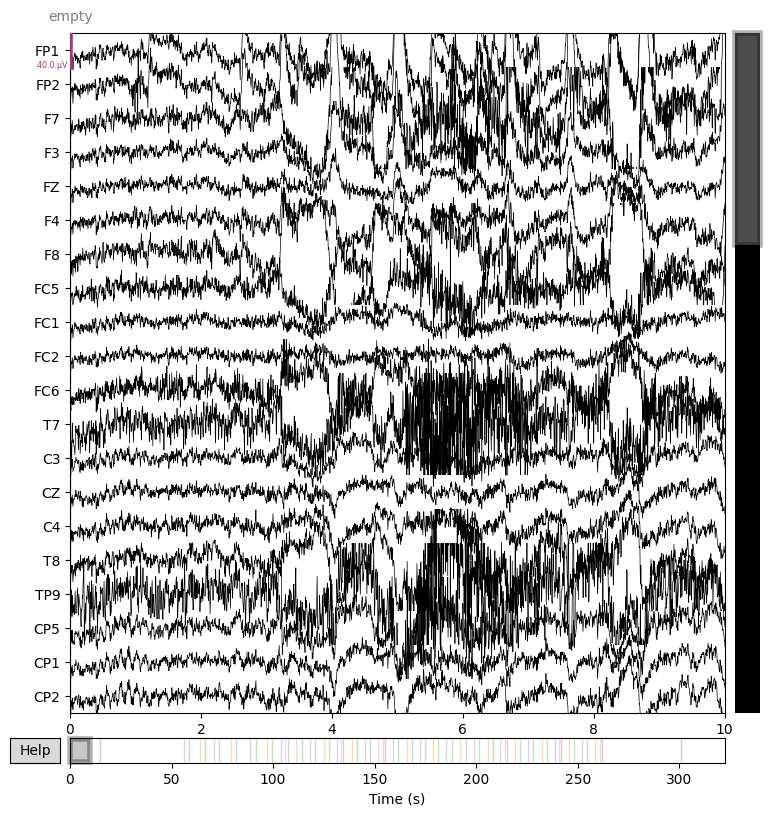

In [ ]:
raw1_eeg_filtered_resampled.plot();

# Creating Epochs on the Filtered Signal
Epochs are used to focus the analysis on the specific brain activity associated with the event of interest

In [ ]:
#raw1_eeg_filtered
tmin = -.3
tmax = 5
baseline = (None,0)

epochs = mne.Epochs(raw1_eeg_filtered_resampled,
                    events=events,
                    event_id=event_dict,
                    tmin=tmin,
                    tmax=tmax,
                    baseline = baseline,
                    preload=True,
                    event_repeated='drop')
epochs

Not setting metadata
66 matching events found
Setting baseline interval to [-0.3, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 66 events and 1061 original time points ...
46 bad epochs dropped


<Epochs |  20 events (all good), -0.3 – 5 s, baseline -0.3 – 0 s, ~10.5 MB, data loaded,
 'Start of flexion': 5
 'Start of extension': 5
 'Standards event': 8
 'Error introduction': 1
 'buttonpress': 1>

tmin and tmax define the time window of each epoch, starting from -0.3 seconds before the event and ending 5 seconds after the event. This time window ensures that the epochs capture the relevant brain activity associated with the event.

46 epochs were identified as bad and discarded during the creation of epochs. Bad epochs often contain artifacts or noise that could distort the analysis. Removing bad epochs helps to improve the quality of the data.

You seem to have overlapping epochs. Some event lines may be duplicated in the plot.


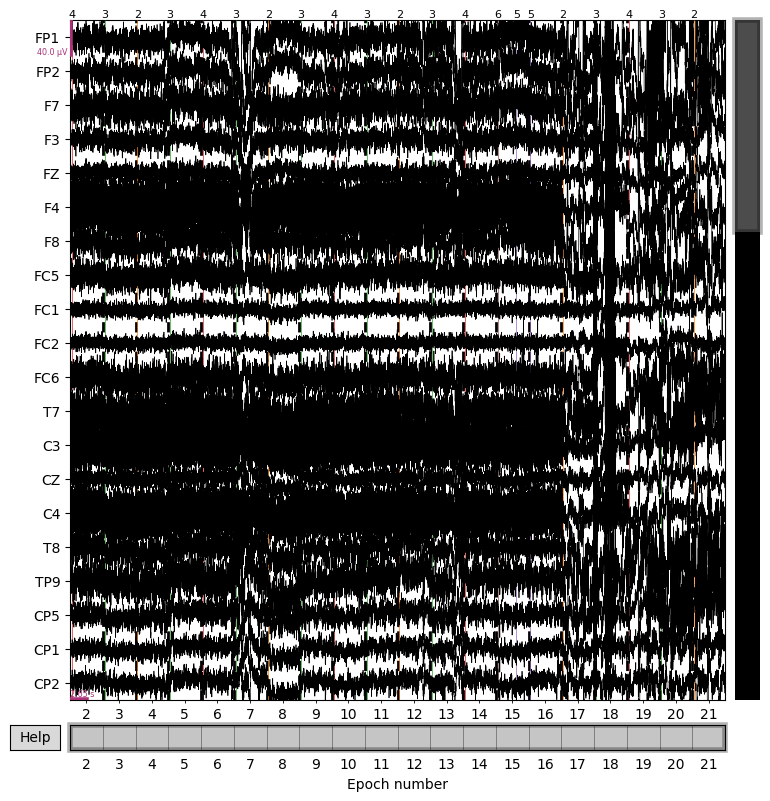

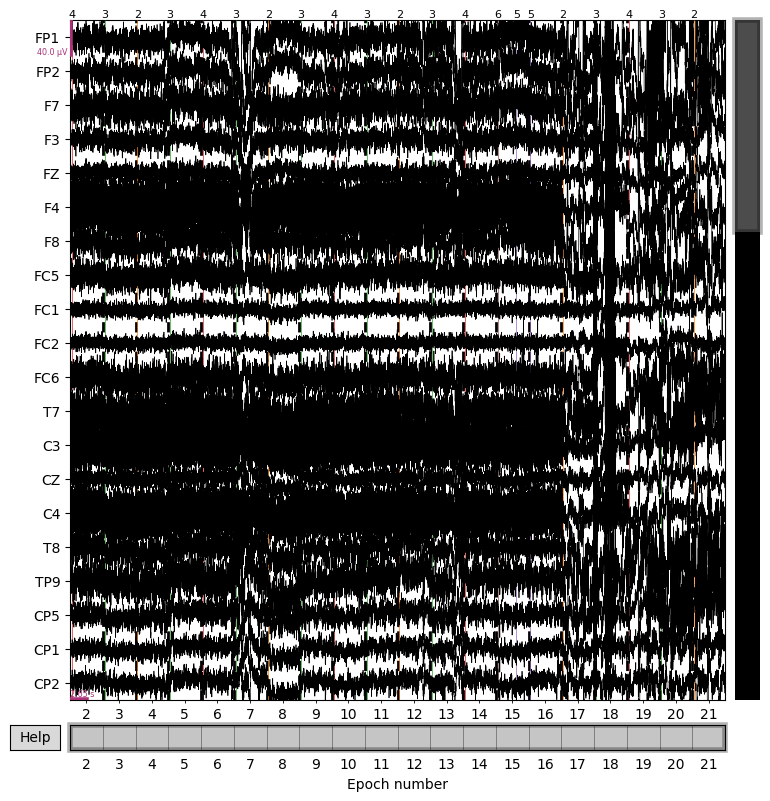

In [ ]:
epochs.plot(events=events)

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...


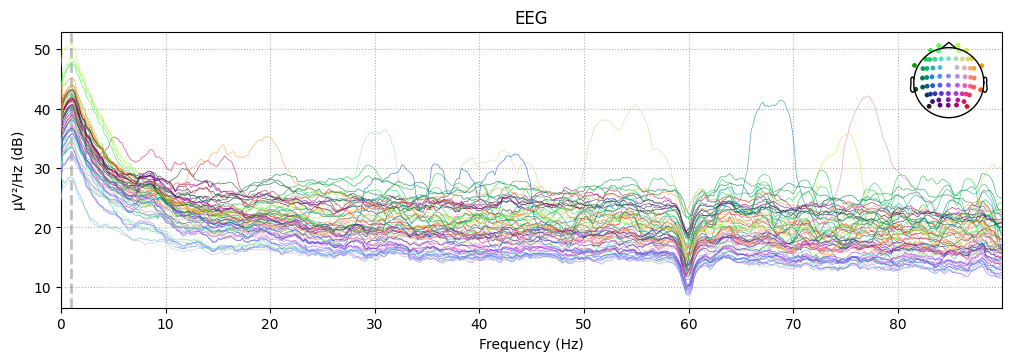

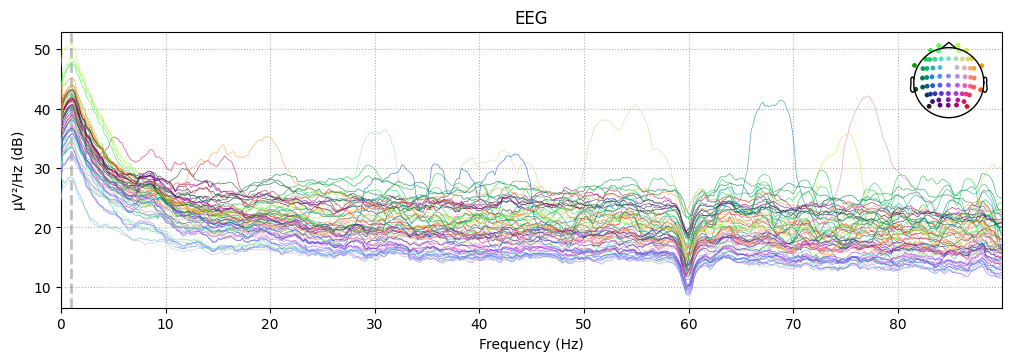

In [ ]:
epochs.plot_psd(fmin = 0, fmax = 90)

The EEG signal is typically divided into the following frequency bands:

Delta: 0.1-4 Hz

Theta: 4-8 Hz

Alpha: 8-12 Hz

Beta: 12-30 Hz

Gamma: 30-70 Hz

he PSD plot shows that the EEG signal has the highest power in the alpha band. This suggests that the participant was in a relaxed state when the EEG data was recorded. There is also a significant amount of power in the beta band, suggesting that the participant was also engaged in some active thinking.


The overall shape of the PSD plot is consistent with a healthy adult EEG. The power decreases with increasing frequency, which is a typical pattern for EEG signals.

## Visualizing Global Field Power
The GFP is a measure of the overall amplitude of the EEG signal across all channels. It is often used to track changes in brain activity over time or across different conditions.

Sure. The image you sent is a plot of the global field power (GFP) of an EEG signal. The GFP is a measure of the overall amplitude of the EEG signal across all channels. It is often used to track changes in brain activity over time or across different conditions.

The plot shows that the GFP of the EEG signal increases sharply at around 1.5 seconds. This suggests that there is a sudden increase in overall brain activity at this time. The GFP then remains elevated for several seconds before gradually returning to baseline levels.

This pattern of GFP activity is consistent with an event-related potential (ERP). ERPs are EEG waveforms that are evoked by specific events, such as stimuli or tasks. The specific ERP waveform that is elicited depends on the nature of the event and the cognitive processes involved.

In this case, the ERP waveform suggests that the participant was paying attention to the event and that it elicited a significant cognitive response. However, it is difficult to say more without knowing more about the specific context in which the EEG data was recorded.

Here are some possible interpretations of the ERP waveform:

The participant may have been presented with a novel or unexpected stimulus.
The participant may have been asked to perform a challenging cognitive task.
The participant may have made a mistake or encountered an unexpected difficulty.
The participant may have experienced a strong emotional response to the event.

Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
combining channels using "gfp"


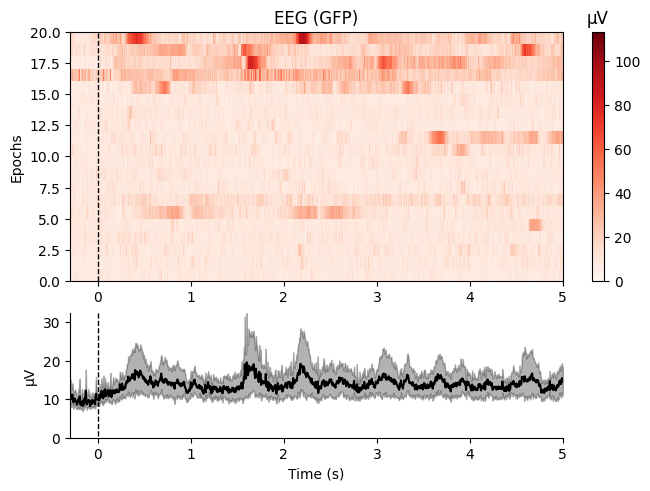

[<Figure size 640x480 with 3 Axes>]

In [ ]:
epochs.plot_image()

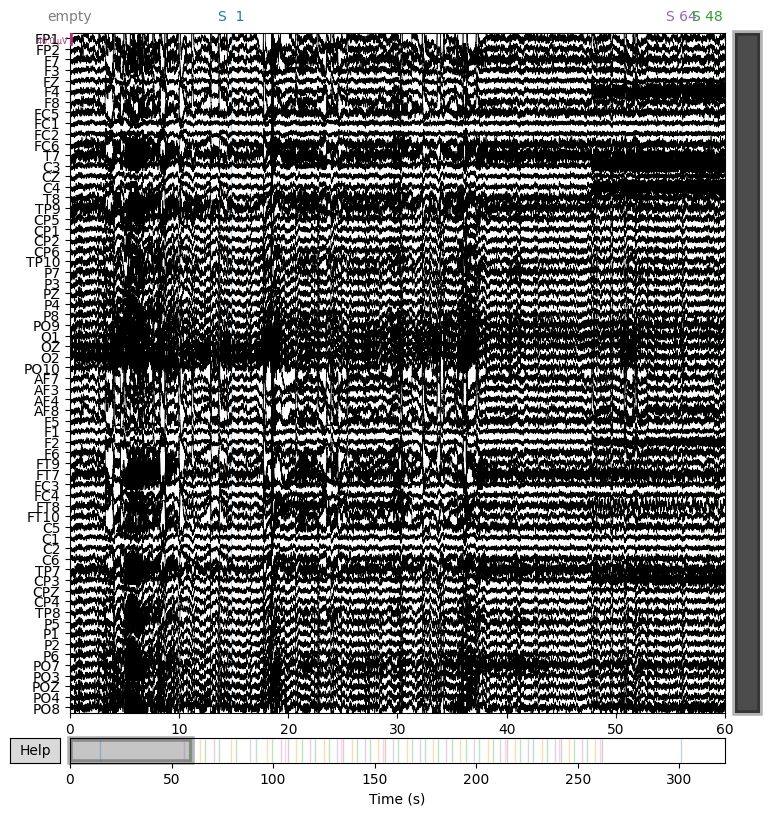

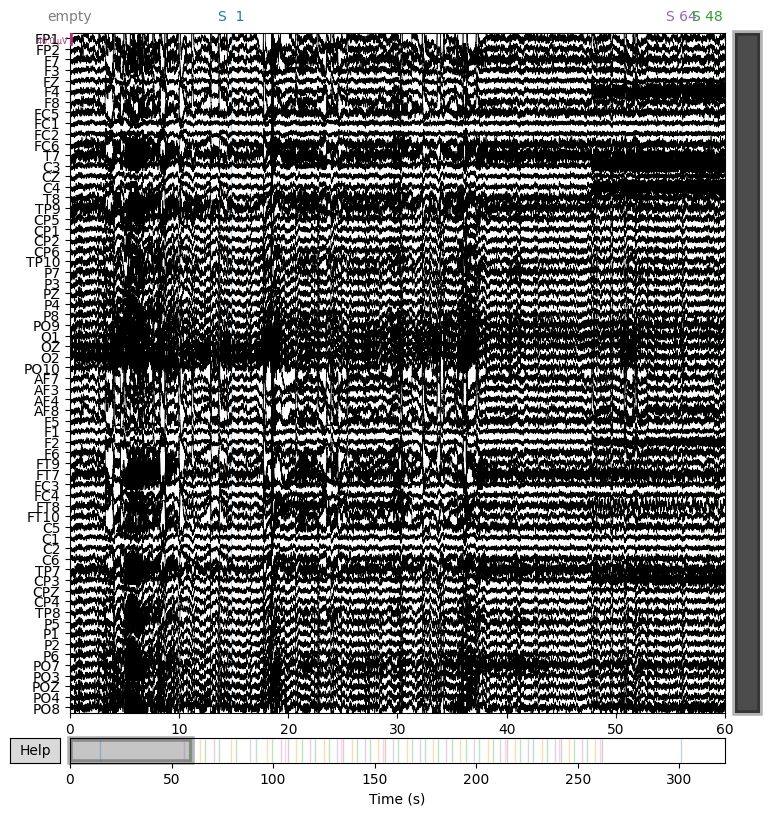

In [ ]:
eeg_channels = mne.pick_types(raw1_eeg_filtered_resampled.info, meg=False, eeg=True, eog=True, exclude=[])
#raw.plot(duration=60, order=None);
raw1_eeg_filtered_resampled.plot(duration=60, order=eeg_channels, n_channels=len(eeg_channels), remove_dc=False)

# Performing Independent Component Analysis on Created Epochs
ICA is a signal processing technique used to decompose a complex signal into a set of statistically independent components. In the context of EEG analysis, ICA aims to identify and separate the underlying neural sources generating the EEG signal.
1. Whitening: The EEG data is first whitened, a process that normalizes the variance of each channel

2. Principal Component Analysis (PCA): PCA is applied to reduce the dimensionality of the whitened data.

3. statistically independent sources of the EEG signal are extracted

4. The ICA algorithm outputs a mixing matrix, which describes how the independent components are mixed together to produce the observed EEG signal

In [ ]:
epochs_ica = epochs

In [ ]:
epochs_ica

<Epochs |  20 events (all good), -0.3 – 5 s, baseline -0.3 – 0 s, ~10.5 MB, data loaded,
 'Start of flexion': 5
 'Start of extension': 5
 'Standards event': 8
 'Error introduction': 1
 'buttonpress': 1>

In [ ]:
ica = mne.preprocessing.ICA(n_components = 15,random_state = 99)
ica.fit(epochs)

Fitting ICA to data using 64 channels (please be patient, this may take a while)


<ipython-input-72-ca9e2c503b74>:2: RuntimeWarning:

The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.



Selecting by number: 15 components
Fitting ICA took 72.4s.


<ICA | epochs decomposition, method: fastica (fit in 1000 iterations on 21220 samples), 15 ICA components (64 PCA components available), channel types: eeg, no sources marked for exclusion>

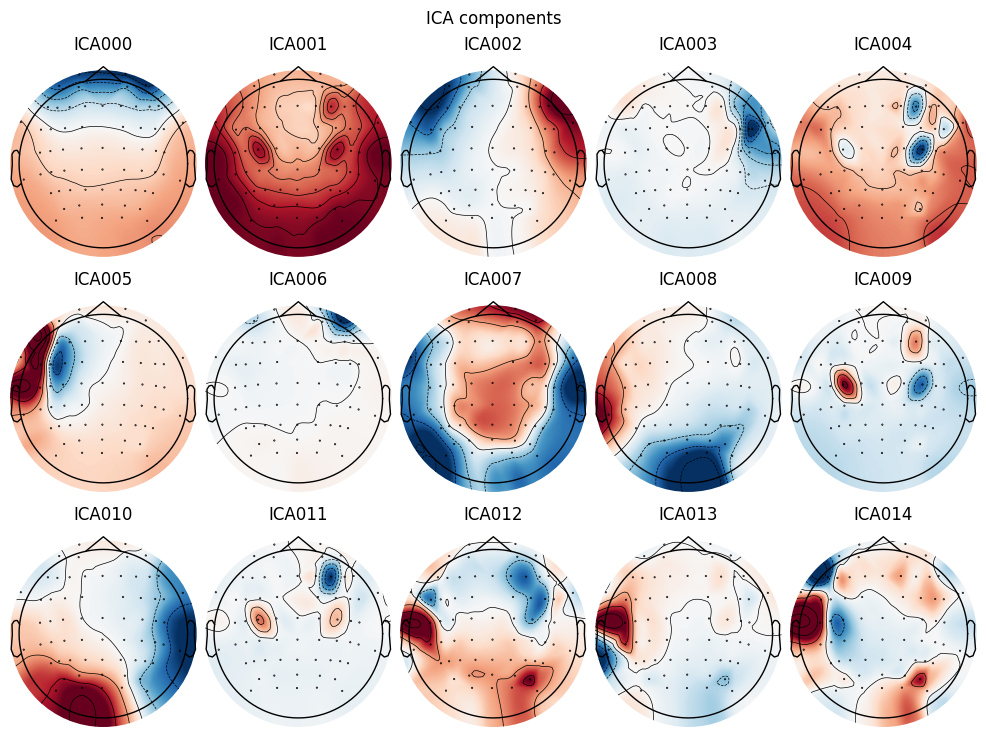

In [ ]:
res = ica.plot_components(range(0,15))

Component 1: Frontal lobe activity, associated with cognitive functions like executive function, attention, and decision-making.

Component 2: Sensorimotor activity, associated with processing sensory information and controlling motor movements.

Component 3: Parietal lobe activity, associated with spatial processing, attention, and sensory integration.

Component 4: Occipital lobe activity, associated with visual processing.

Component 5: Complex network of brain regions involved in multiple cognitive functions.

Components 6-8: Possible association with visual processing.

Components 9-11: Possible association with auditory processing.

Component 12: Possible association with sensorimotor activity.

Component 13: Possible association with attention and cognitive control.
Components 14-15: Possible association with artifact.

In [ ]:
print(ar)

<class 'autoreject.autoreject.AutoReject'>


# Auto Rejecting Bad Epochs using AutoReject

Autoreject is an algorithm for automatically rejecting bad epochs from EEG data. It is based on the idea of using cross-validation to estimate an optimal peak-to-peak threshold for identifying bad epochs. The algorithm then uses this threshold to identify and reject bad epochs from the EEG data.


In [ ]:
 from autoreject import AutoReject
 ar = AutoReject(cv = 5)
 ar.fit(epochs_ica) # fitting on a few epochs
 epochs_clean, reject_log = ar.transform(epochs_ica, return_log = True)

Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/64 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]





Estimated consensus=0.70 and n_interpolate=32


  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

Dropped 4 epochs: 16, 17, 18, 19


In [ ]:
epochs_clean

<Epochs |  16 events (all good), -0.3 – 5 s, baseline -0.3 – 0 s, ~8.4 MB, data loaded,
 'Start of flexion': 4
 'Start of extension': 4
 'Standards event': 6
 'Error introduction': 1
 'buttonpress': 1>

In [ ]:
# Access the channel labels of rejected epochs
rejected_epochs_labels = reject_log.ch_names

# Access the reasons for rejecting epochs
rejected_epochs_reasons = reject_log.labels

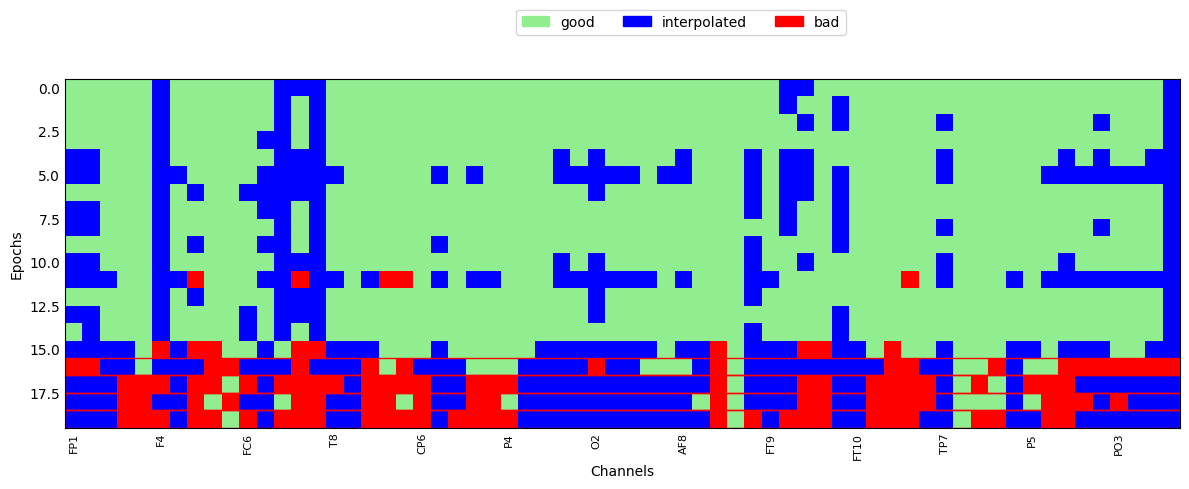

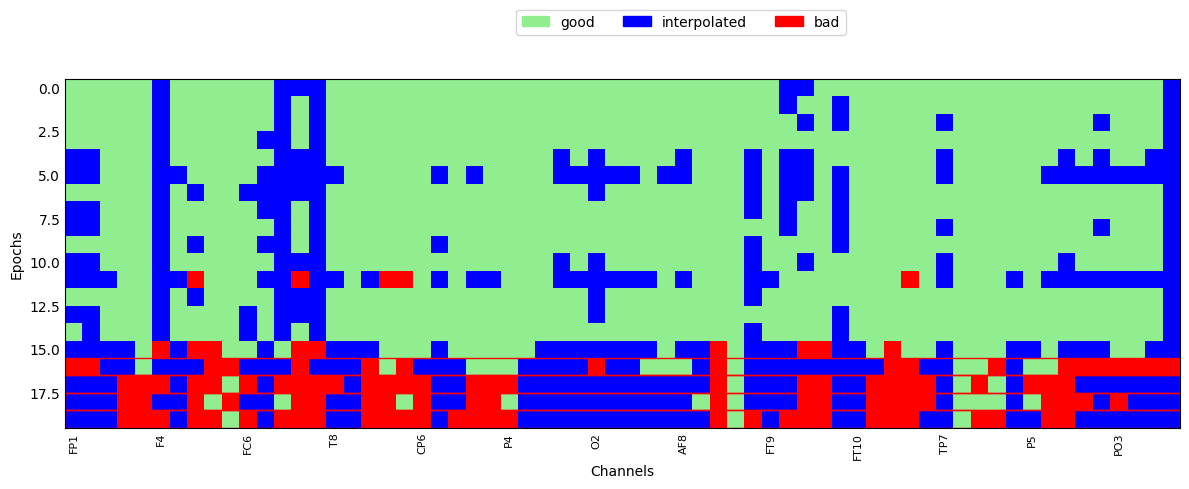

In [ ]:
reject_log.plot()

In [ ]:
rejected_epochs_idx, rejected_epochs_labels, rejected_epochs_reasons

(array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False,  True,  True,
         True,  True]),
 ['FP1',
  'FP2',
  'F7',
  'F3',
  'FZ',
  'F4',
  'F8',
  'FC5',
  'FC1',
  'FC2',
  'FC6',
  'T7',
  'C3',
  'CZ',
  'C4',
  'T8',
  'TP9',
  'CP5',
  'CP1',
  'CP2',
  'CP6',
  'TP10',
  'P7',
  'P3',
  'PZ',
  'P4',
  'P8',
  'PO9',
  'O1',
  'OZ',
  'O2',
  'PO10',
  'AF7',
  'AF3',
  'AF4',
  'AF8',
  'F5',
  'F1',
  'F2',
  'F6',
  'FT9',
  'FT7',
  'FC3',
  'FC4',
  'FT8',
  'FT10',
  'C5',
  'C1',
  'C2',
  'C6',
  'TP7',
  'CP3',
  'CPZ',
  'CP4',
  'TP8',
  'P5',
  'P1',
  'P2',
  'P6',
  'PO7',
  'PO3',
  'POZ',
  'PO4',
  'PO8'],
 array([[0., 0., 0., ..., 0., 0., 2.],
        [0., 0., 0., ..., 0., 0., 2.],
        [0., 0., 0., ..., 0., 0., 2.],
        ...,
        [2., 2., 2., ..., 2., 2., 2.],
        [2., 2., 2., ..., 2., 2., 2.],
        [2., 2., 2., ..., 2., 2., 2.]]))

You seem to have overlapping epochs. Some event lines may be duplicated in the plot.


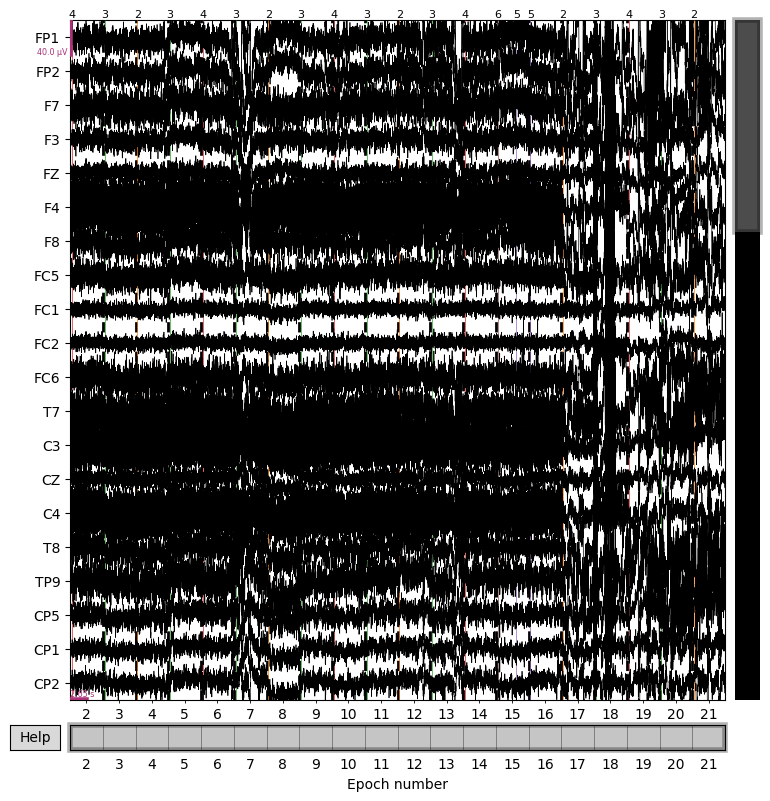

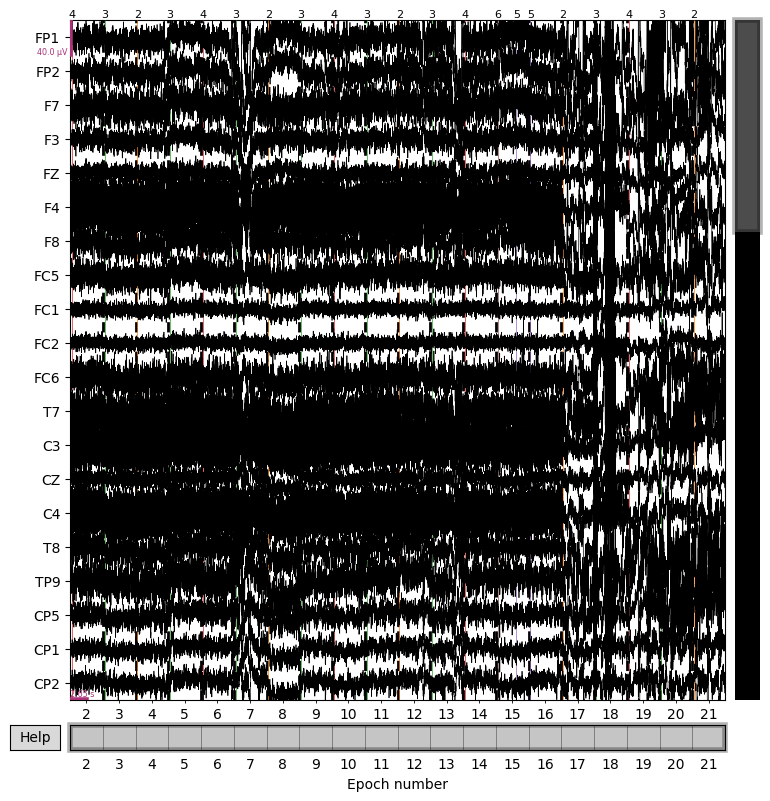

In [ ]:
epochs_ica.plot(events=events)

In [ ]:
epochs_standard = epochs_clean['Standards event']

# Plotting ERP and Joint Plot

Event-related potential (ERP) is a measure of the electrical activity of the brain in response to a specific event or stimulus. ERPs are typically recorded using electroencephalography (EEG), a non-invasive technique that measures the electrical activity of the brain through electrodes placed on the scalp.

The specific interpretation of the ERP waveform depends on the type of event or stimulus that was presented. However, in general, the ERP waveform can provide insights into the following:


How attention is allocated and shifted.
How sensory information is processed.
How cognitive processes are initiated and executed.
How errors and unexpected events are processed.

In [ ]:
erp = epochs_clean.average(picks='eeg')

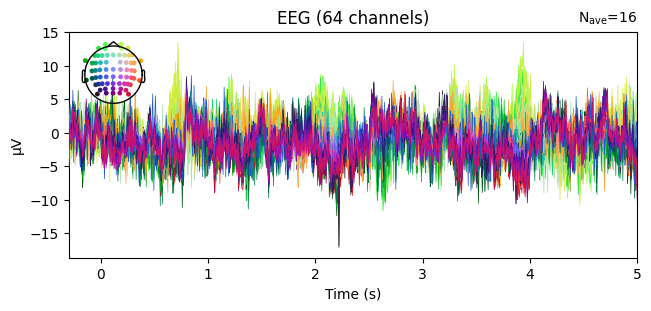

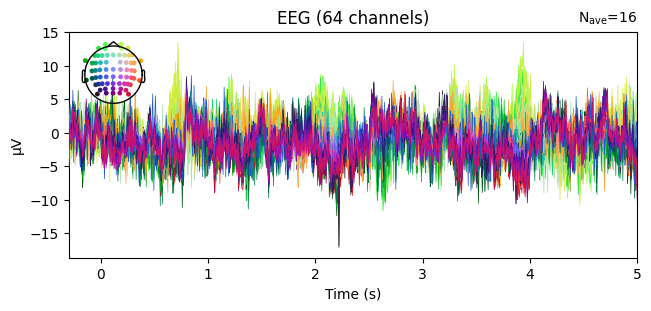

In [ ]:
erp.plot(spatial_colors=True)

No projector specified for this dataset. Please consider the method self.add_proj.


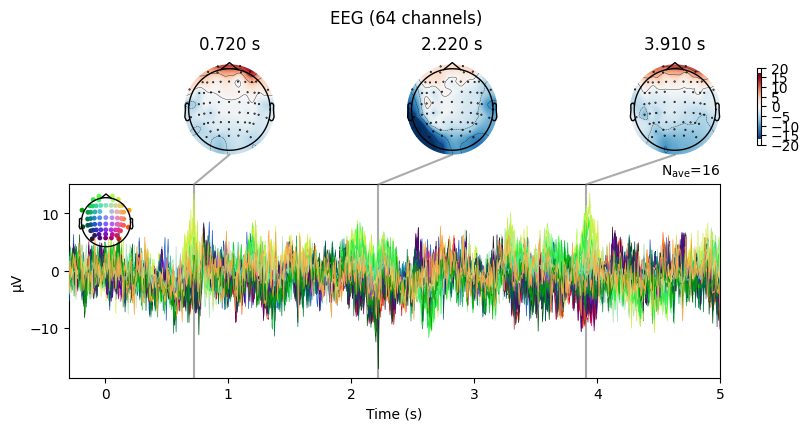

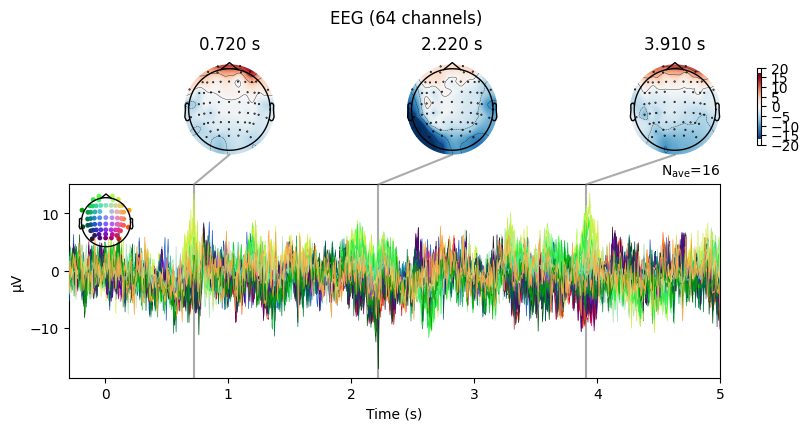

In [ ]:
erp.plot_joint()